In [1]:
import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import save_image
from torchvision.datasets import MNIST
import os
import sys
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [74]:
batch_size = 256

img_transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = MNIST('./data', transform=img_transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [153]:
def show_data(X, y, size=32):
    plt.figure(figsize=(6, 7))
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(X[i].reshape(size, size), cmap=plt.cm.Greys_r)
        plt.title(y[i])
        plt.axis('off')
    plt.show()

In [154]:
X, y = next(iter(dataloader))
y = y.numpy()

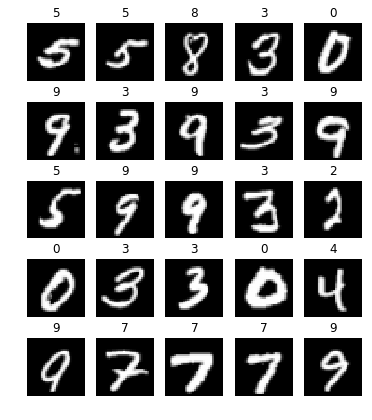

In [155]:
show_data(X, y)

In [76]:
def Conv_BN_ReLU(in_channels, num_of_filters):
    return nn.Sequential(
                            nn.Conv2d(in_channels, num_of_filters, kernel_size=4, stride=2, padding=1),
                            nn.BatchNorm2d(num_features=num_of_filters),
                            nn.ReLU()
                        )

def deConv_BN_ReLU(in_channels, num_of_filters):
    return nn.Sequential(
                            nn.ConvTranspose2d(in_channels, num_of_filters, kernel_size=4, stride=2, padding=1),
                            nn.BatchNorm2d(num_features=num_of_filters),
                            nn.ReLU()
                        )

In [145]:
class ConvAE(nn.Module):
    def __init__(self):
        super(ConvAE, self).__init__()
        self.encoder = nn.Sequential(
            Conv_BN_ReLU(1, 16),
            Conv_BN_ReLU(16, 32),
            Conv_BN_ReLU(32, 64),
            Conv_BN_ReLU(64, 128),
        )
        self.decoder = nn.Sequential(
            deConv_BN_ReLU(128, 64),
            deConv_BN_ReLU(64, 32),
            deConv_BN_ReLU(32, 16),
            deConv_BN_ReLU(16, 1)
        )
        
    def encode(self, x):
        return self.encoder(x)
    
    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        return self.decoder(self.encoder(x))

In [146]:
GPU_NUMBER = 3

In [148]:
def train(model, optimizer, num_epochs=100, criterion=nn.MSELoss()):
    losses = []
    for epoch in range(num_epochs):
        for data in dataloader:
            img, _ = data
            img = Variable(img).cuda(GPU_NUMBER)
            
            output = model(img)
            loss = criterion(output, img)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        clear_output(wait=True)
        losses.append(loss.data[0])
        plt.plot(losses)
        plt.grid()
        plt.show()
        sys.stdout.write('\repoch [{}/{}], loss:{:.4f}'.format(epoch+1, num_epochs, loss.data[0]))

In [151]:
learning_rate = 1e-4
model = ConvAE().cuda(GPU_NUMBER)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,
                             weight_decay=1e-5)

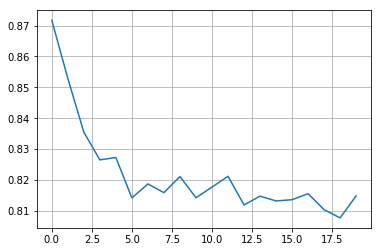

epoch [20/20], loss:0.8149CPU times: user 3min 35s, sys: 4.16 s, total: 3min 39s
Wall time: 3min 39s


In [152]:
%%time

train(model, optimizer, num_epochs=20)

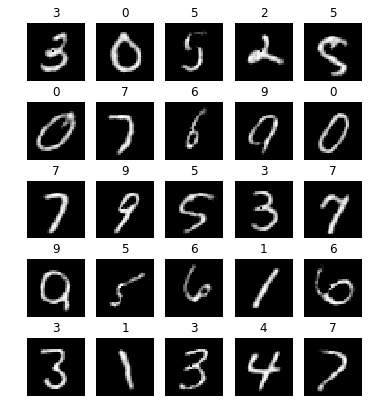

In [156]:
X, y = next(iter(dataloader))
y = y.numpy()
reconstructed = model(X.cuda(GPU_NUMBER)).data.cpu().numpy()
show_data(reconstructed, y)